# LSTM Model 3 on kaggle competition dataset 

Here you can see a multi-input (title and text column) model was created, where the two previous architectures (LSTM1 and LSTM2) are merged in one. 
This model is done by Andrii Shchur, 2020
Here is its [article](https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052)
![image.png](../../images/model3.png)

- The kaggle dataset contains a lot politic topics 
- The Kaggle competition dataset : it is a full open training dataset that contains news articles and their title, author and label (reliable and unreliable)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

### <span style="background-color: #FFFF00">In this notebook, I have kept the orogonal validation techenique and the oroginal preprocessing of the dataset </span>

## Importing packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import time
#Loading tensorflow and keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import plot_model
from tensorflow.keras.layers import Input
#Loading ntlk
import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer
#Loading sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
#Loading K-folds
from sklearn.model_selection import StratifiedKFold
#Loading the model 
import sys  
sys.path.insert(0, '../../models')
from PY.model3 import get_model

Using TensorFlow backend.


## Paths 

In [2]:
DATA_DIR = '../../../../Data'
CODE_DIR_H5='../../models/H5'
# Create a path for the saving location of the model
MODEL_DIR_H5 = CODE_DIR_H5 + '/model3_Kaggle.h5'

## Loading data 

In [3]:
# Load train data
train = pd.read_csv(op.join(DATA_DIR, 'Kaggle_competition/Claims_to_work_with/claims.csv'))
train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [4]:
# get label
X_train=train.drop('label',axis=1)
y_train=train['label']

In [5]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [6]:
#dataset Preprocessing
ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

In [7]:
# One hot representation
onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

In [8]:
# sequences representation
sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

In [9]:
# check shape 
print(len(embedded_doc_title),y_train.shape)
print(len(embedded_doc_text),y_train.shape)

20800 (20800,)
20800 (20800,)


In [10]:
# final data for NN
X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
y_final=np.array(y_train)
print(X_final_title.shape,y_final.shape)
print(X_final_text.shape,y_final.shape)

(20800, 20) (20800,)
(20800, 1000) (20800,)


In [11]:
embedding_vector_feature_title = 10
embedding_vector_feature_text = 100
input_title = Input(shape=(sent_length_title,))
input_text = Input(shape=(sent_length_text,))

In [14]:
cvscores1 = []
cvscores2 = []
cvscores3 = []
cvscores4 = []
i=0
start=time.time()
for i in range(10): 
    model=get_model(vo_size,embedding_vector_feature_title,embedding_vector_feature_text,input_title,input_text)
    history = model.fit(x=[X_final_title,X_final_text], y=y_final, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
    print("------subset number", ,"------")
    print("%s: %.2f%%" % (model.metrics_names[1], history[1]*100))
    cvscores1.append(history[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[2], history[2]*100))
    cvscores2.append(history[2] * 100)
    print("%s: %.2f%%" % (model.metrics_names[3], history[3]*100))
    cvscores3.append(history[3] * 100)
    print("%s: %.2f%%" % (model.metrics_names[4], history[4]*100))
    cvscores4.append(history[4] * 100)
print("--------------------------------------------" )   
print("accuracy","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)))
print("precision","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("recall","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores3), np.std(cvscores3)))
print("f1-mesure","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores4), np.std(cvscores4)))
end=time.time()

Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 817s 49ms/sample - loss: 0.4523 - accuracy: 0.7905 - precision_mesure: 0.8072 - recall_mesure: 0.8046 - f1_mesure: 0.7905 - val_loss: 0.2697 - val_accuracy: 0.8870 - val_precision_mesure: 0.9307 - val_recall_mesure: 0.8388 - val_f1_mesure: 0.8816
Epoch 2/10
16640/16640 [==============================] - 782s 47ms/sample - loss: 0.1900 - accuracy: 0.9249 - precision_mesure: 0.9169 - recall_mesure: 0.9359 - f1_mesure: 0.9250 - val_loss: 0.1695 - val_accuracy: 0.9392 - val_precision_mesure: 0.9032 - val_recall_mesure: 0.9851 - val_f1_mesure: 0.9421
Epoch 3/10
16640/16640 [==============================] - 786s 47ms/sample - loss: 0.1265 - accuracy: 0.9543 - precision_mesure: 0.9434 - recall_mesure: 0.9658 - f1_mesure: 0.9539 - val_loss: 0.1240 - val_accuracy: 0.9550 - val_precision_mesure: 0.9345 - val_recall_mesure: 0.9795 - val_f1_mesure: 0.9561
Epoch 4/10
16640/16640 [============

TypeError: 'History' object is not subscriptable

In [14]:
# Save the model
model.save(MODEL_DIR_H5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    50000       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1000, 128)    117248      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           lstm_1[0][0]                     
______________________________________________________________________________________________

In [15]:
print("accuracy","%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("precision","%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
print("recall","%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
print("f1-mesure","%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))

accuracy accuracy: 99.12%
precision precision_mesure: 99.23%
recall recall_mesure: 99.02%
f1-mesure f1_mesure: 99.10%


In [16]:
print('time of training' , end-start)

time of training 18105.289485931396


## Graphs 

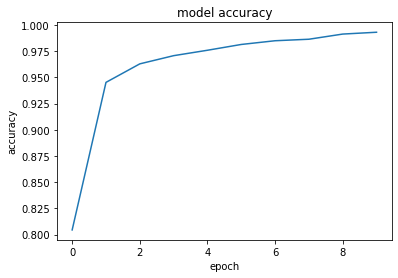

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

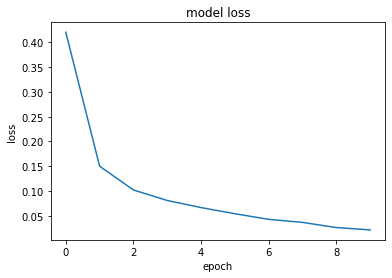

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

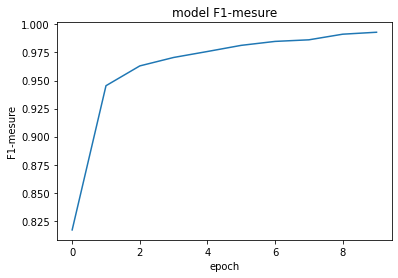

In [19]:
# summarize history for f1-mesure
plt.plot(history.history['f1_mesure'])
plt.title('model F1-mesure')
plt.ylabel('F1-mesure')
plt.xlabel('epoch')
plt.show()

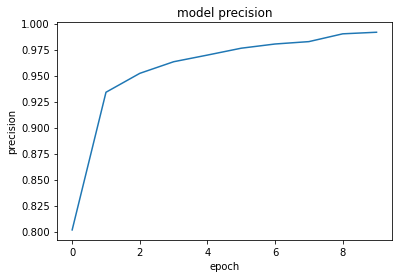

In [20]:
# summarize history for precision
plt.plot(history.history['precision_mesure'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

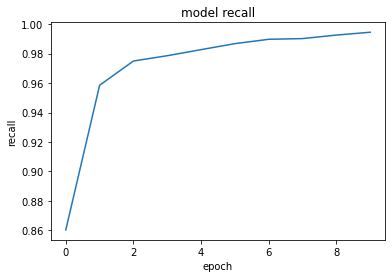

In [21]:
# summarize history for recall
plt.plot(history.history['recall_mesure'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()